In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K



In [2]:
file_path = 'city_hour.csv'
data = pd.read_csv(file_path)

data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

data.fillna(method='ffill', inplace=True)

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
target = 'AQI'

data = data.dropna(subset=[target])



C:\Users\Admin\AppData\Local\Temp\ipykernel_3772\674091562.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

def create_sequences(data, target, sequence_length=12):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length][target]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 24
X, y = create_sequences(data, target, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Attention Layer
    attention = Attention()(x)

    # Fully Connected Layers
    x = Dense(64, activation='relu')(attention)  # Reduced from 128 to 64
    x = Dropout(0.2)(x)  # Increased Dropout rate for regularization
    outputs = Dense(1, activation='linear')(x)  # Regression output for AQI prediction
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

input_shape = (sequence_length, len(features)) 
model = create_model(input_shape)
model.summary()

history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')


KeyboardInterrupt: 

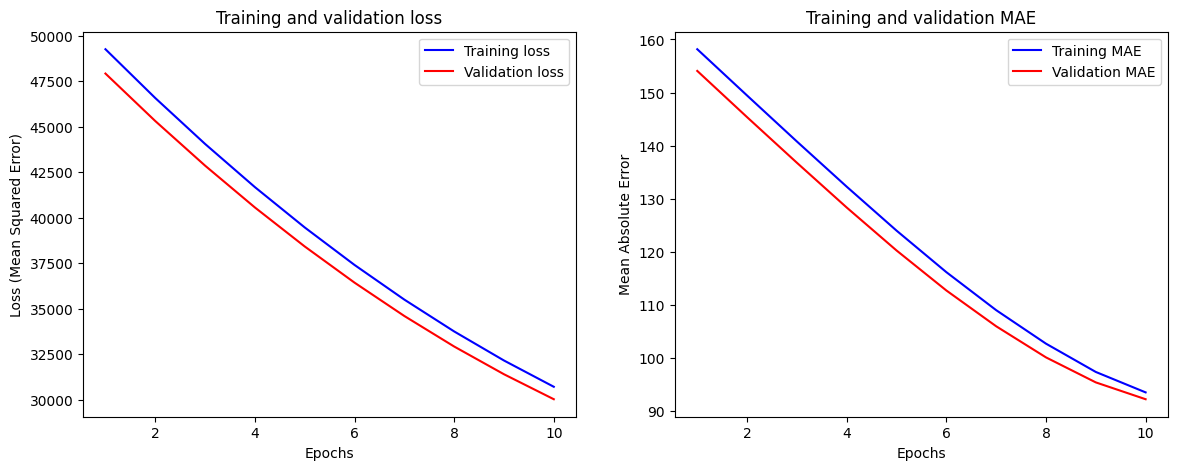

4420/4420 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 29698.6270 - mae: 92.2990
Test Loss (MSE): 30020.90625
Test MAE: 92.26445007324219


In [4]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    epochs = range(1, len(loss) + 1)
    
    # Plot Loss
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'b', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.show()

# Call the function to plot metrics
plot_metrics(history)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_3772\3536128568.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


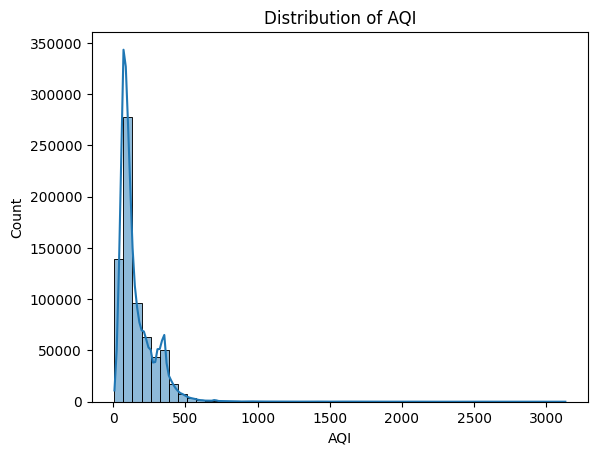

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           134 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,847 (171.28 KB)

 Trainable params: 43,847 (171.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 21.8006 - mae: 4.6127 - val_loss: 16.2396 - val_mae: 3.9689
Epoch 2/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 14.5883 - mae: 3.7499 - val_loss: 10.1534 - val_mae: 3.1090
Epoch 3/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 8.8801 - mae: 2.8902 - val_loss: 5.5802 - val_mae: 2.2567
Epoch 4/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 4.6923 - mae: 2.0422 - val_loss: 2.4999 - val_mae: 1.4257
Epoch 5/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 1.9810 - mae: 1.2277 - val_loss: 0.8682 - val_mae: 0.7273
Epoch 6/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.7005 - mae: 0.6431 - val_loss: 0.4888 - val_mae: 0.5659
Epoch 7/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.4902 - mae: 0.5686 - val_loss: 0.4878 - val_mae: 0.5685
Epoch 8/75
8840/8840 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 0.4882 - mae: 0.5688 - val_loss: 0.4878 - val_mae: 0.5688
Epoch 9/75
8840/8840 ━━━━━━━

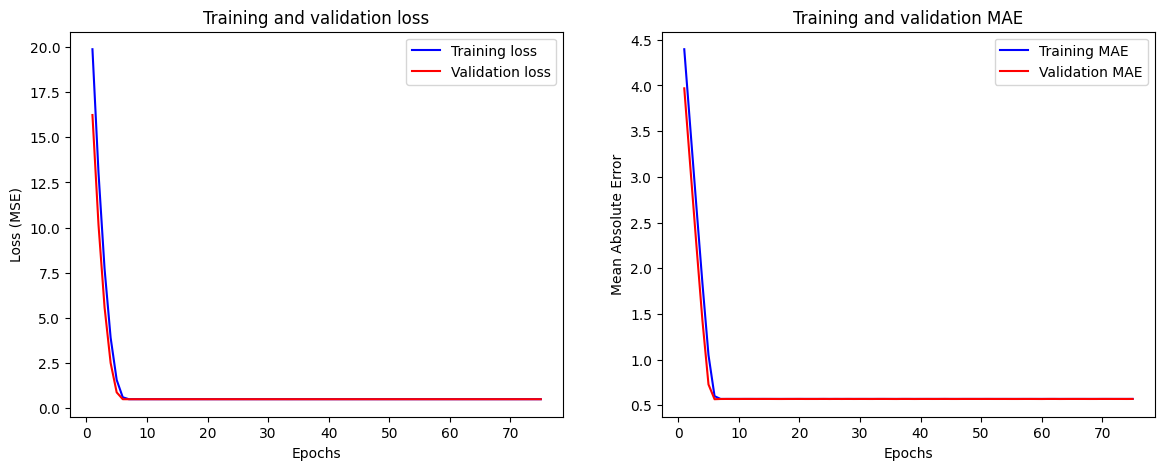

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Layer, LeakyReLU
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

file_path = 'city_hour.csv' 
data = pd.read_csv(file_path)

data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

data.fillna(method='ffill', inplace=True)

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
target = 'AQI'

data = data.dropna(subset=[target])

sns.histplot(data[target], bins=50, kde=True)
plt.title("Distribution of AQI")
plt.show()

data['AQI_log'] = np.log1p(data['AQI'])
target = 'AQI_log'

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

def create_sequences(data, target, sequence_length=24):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length][target]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 24  
X, y = create_sequences(data, target, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def create_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=64, kernel_size=3, activation=None, padding='same')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation=None, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2)(x)

    attention = Attention()(x)

    x = Dense(128, activation='relu')(attention)
    x = Dropout(0.2)(x) 
    outputs = Dense(1, activation='linear')(x)  

    optimizer = Adam(learning_rate=0.0001)
    model = Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

input_shape = (sequence_length, len(features))
model = create_model(input_shape)
model.summary()

history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
rmse = np.sqrt(loss)  
print(f'Test Loss (MSE): {loss}, Test RMSE: {rmse}, Test MAE: {mae}')

def plot_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'b', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

# Call the function to plot metrics
plot_metrics(history)


4420/4420 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


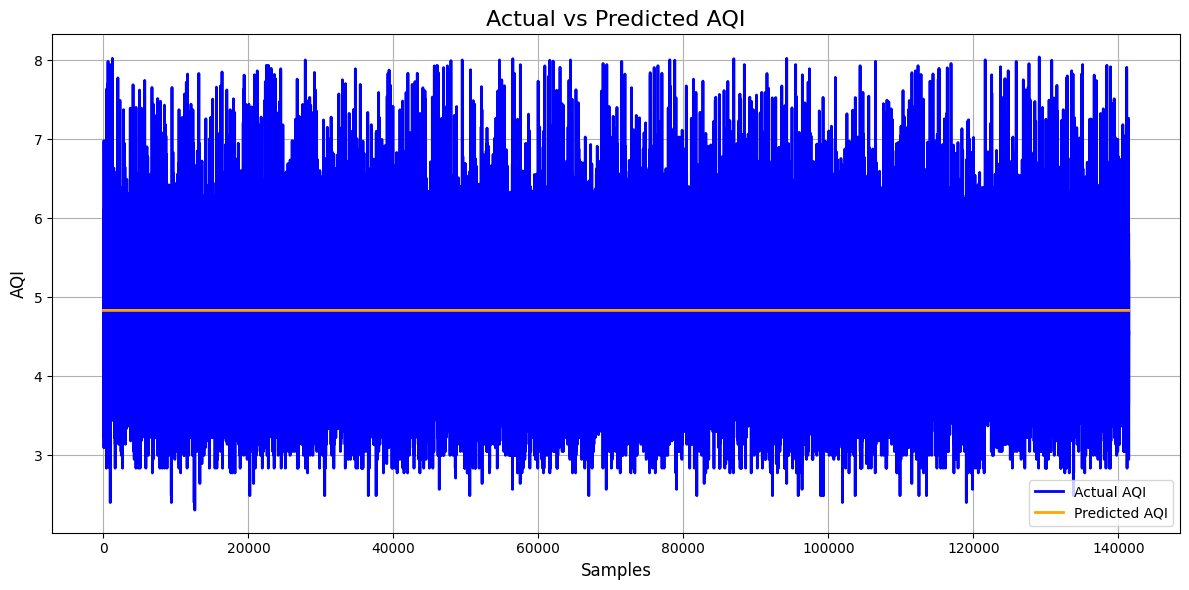

In [5]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual AQI', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted AQI', color='orange', linewidth=2)
plt.title('Actual vs Predicted AQI', fontsize=16)
plt.xlabel('Samples', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
model.save("1D_CNN.keras")